# Prediction stock returns with linear regression

## Imports & Settings

In [335]:
from pathlib import Path
from time import time
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf`
from scipy.stats import spearmanr, norm

from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold

from empyrical import max_drawdown, sortino_ratio
from custom_scoring import spearman_corr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

In [156]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice

## Load Data

In [3]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [4]:
data = data[data.dollar_vol_rank<100]

In [5]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109667 entries, (AAL, 2013-07-25 00:00:00) to (ZTS, 2014-12-04 00:00:00)
Data columns (total 64 columns):
volume                   109667 non-null float64
dollar_vol               109667 non-null float64
dollar_vol_rank          109667 non-null float64
rsi                      109667 non-null float64
bb_high                  109667 non-null float64
bb_low                   109667 non-null float64
atr                      109667 non-null float64
macd                     109667 non-null float64
return_1d                109667 non-null float64
return_5d                109667 non-null float64
return_10d               109667 non-null float64
return_21d               109667 non-null float64
return_42d               109667 non-null float64
return_63d               109667 non-null float64
return_1d_lag1           109667 non-null float64
return_5d_lag1           109667 non-null float64
return_10d_lag1          109667 non-null float64
return_21d_

### Create Model Data

In [7]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Linear Regression with sklearn

### Custom TimeSeriesCV

In [78]:
class TimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, train_period_length=12, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.train_period_length = train_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, chunk_size):
        for i in range(0, len(l), chunk_size):
            yield l[i:i + chunk_size]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index.get_level_values('date')
                        .unique()
                        .sort_values(ascending=False))
        test_dates = unique_dates[:self.test_end]
        dates = X.reset_index()[['date']]
        for test_date in self.chunks(test_dates, self.test_period_length):
            test_end = min(test_date)
            idx = unique_dates.get_loc(test_end) + self.train_period_length + 1
            if len(unique_dates) <= idx:
                break

            train_start = unique_dates[idx]
            train_idx = dates[(dates.date < test_end) &
                              (dates.date > train_start)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Generate predictions with LinearRegression 

In [220]:
n_splits = 4 * 252
cv = TimeSeriesCV(n_splits=n_splits,
                  test_period_length=1,
                  train_period_length=252)
lr = LinearRegression()
target = 'target_5d'
test_results, result_idx, preds = [], [], []
ics = 0
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    if len(y_test) < 50:
        continue
    lr.fit(X=X_train, y=y_train)

    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    ic, pval = spearmanr(y_pred, y_test)
    ics += ic
    if i % 100 == 0:
        print(f'{i:03} | {ics/i:>7.2%}')

    test_results.append([rmse, ic, pval])
    preds.append(y_test.to_frame('actuals').assign(predicted=y_pred))
    result_idx.append(y_test.index.get_level_values('date').min())

lr_result = pd.DataFrame(test_results, columns=[
    'rmse', 'ic', 'pval'], index=result_idx)
lr_result.dropna().to_hdf('data.h5', 'lr/metrics')
pd.concat(preds).to_hdf('data.h5', 'lr/predictions')

100 |   3.13%
200 |   0.71%
300 |   0.79%
400 |   0.92%
500 |   2.60%
600 |   2.66%
700 |   3.14%
800 |   3.89%


In [91]:
lr_result = pd.read_hdf('data.h5', 'lr/metrics')
lr_preds = pd.read_hdf('data.h5', 'lr/predictions')

In [92]:
lr_result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 867 entries, 2017-11-29 to 2014-06-23
Data columns (total 3 columns):
rmse    867 non-null float64
ic      867 non-null float64
pval    867 non-null float64
dtypes: float64(3)
memory usage: 27.1 KB


In [311]:
def plot_ic_distribution(df, fname=None, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2%}\nMedian: {median:5.2%}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)    

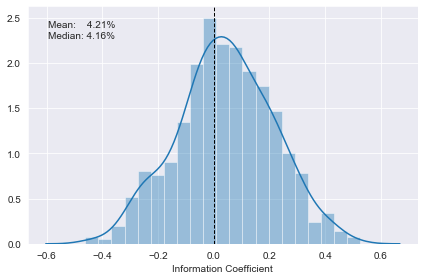

In [219]:
plot_ic_distribution(lr_result, fname='lr_ic_dist')

In [231]:
def plot_rolling_ic(df, fname):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.rolling(21).mean()
    rolling_result.ic.plot(ax=axes[0], title='Information Coefficient', lw=1)
    axes[0].axhline(0, lw=1, ls='--', color='k')

    rolling_result.rmse.plot(ax=axes[1], title='Root Mean Squared Error', lw=1, ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)

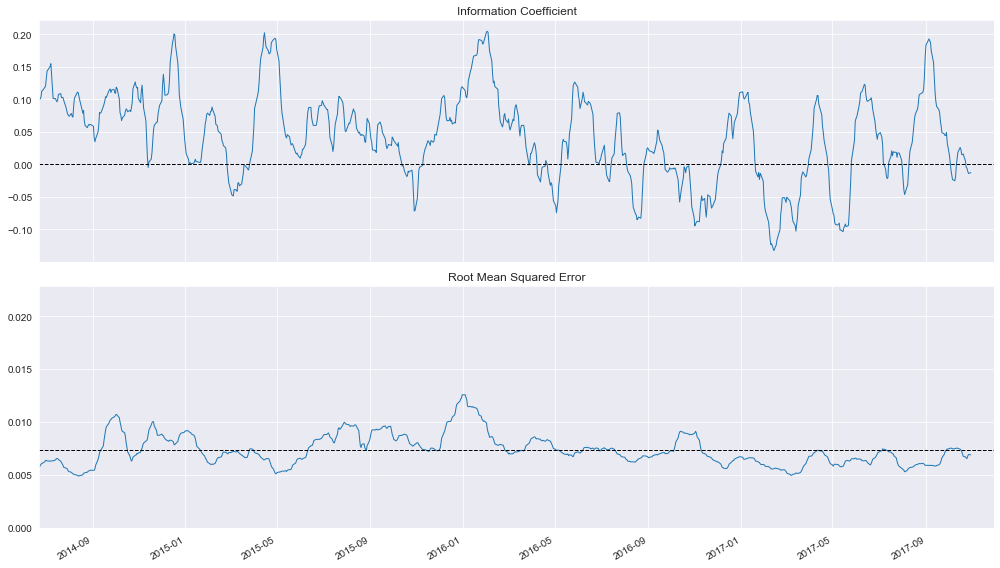

In [232]:
plot_rolling_ic(lr_result, fname='lr_ic_rolling')

In [214]:
def plot_preds_scatter(df, ticker=None, fname=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True,
                      ci=None,
                      line_kws={'lw':1, 'color':'k'},
                      scatter_kws={'s': 1},
                      data=preds,
                      stat_func=spearmanr,
                      kind='reg')
    j. ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j. ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j. ax_joint.set_xlabel('Predicted')
    j. ax_joint.set_ylabel('Actuals')
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


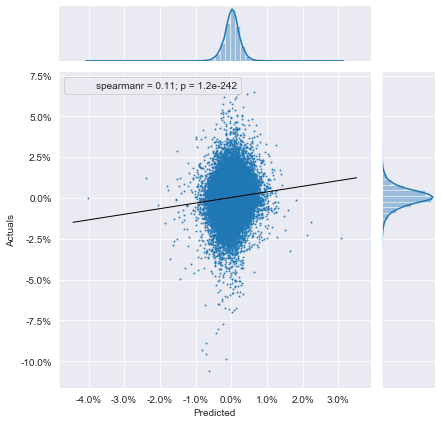

In [215]:
plot_preds_scatter(lr_preds, fname='lr_preds')

## Ridge Regression

In [ ]:
n_splits = 252 * 4
alphas = np.logspace(-5, 5, 11)
alphas = sorted(list(alphas) + list(alphas * 5))
cv = TimeSeriesCV(n_splits=n_splits,
                  test_period_length=1,
                  train_period_length=252)
X = X.drop([c for c in X.columns if 'year' in c], axis=1)
target = 'target_5d'
ridge_coeffs, ridge_results, preds = {}, [], []
for alpha in alphas:
    print(alpha)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = rmses = 0
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        if len(y_test) < 40:
            continue

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        ic, pval = spearmanr(y_pred, y_test)

        preds.append(y_test.to_frame('actuals').assign(
            predicted=y_pred, alpha=alpha))
        date = y_test.index.get_level_values('date').min()
        ridge_results.append([alpha, i, date, rmse, ic, pval])
        coeffs.append(pipe['model'].coef_)
        ics += ic
        rmses += rmse
        if i % 100 == 0:
            print(f'{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {rmses/i:>7.2%}')

    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

cols = ['alpha', 'split', 'date', 'rmse', 'ic', 'pval']
ridge_results = pd.DataFrame(ridge_results, columns=cols)
ridge_results.to_hdf('data.h5', 'ridge/metrics')
ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')
pd.concat(preds).to_hdf('data.h5', 'ridge/predictions')

### Evaluate Ridge Results

In [242]:
ridge_results = pd.read_hdf('data.h5', 'ridge/metrics')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_preds = pd.read_hdf('data.h5', 'ridge/predictions')

In [255]:
ridge_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19074 entries, 0 to 19073
Data columns (total 6 columns):
alpha    19074 non-null float64
split    19074 non-null int64
date     19074 non-null datetime64[ns]
rmse     19074 non-null float64
ic       19074 non-null float64
pval     19074 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.0 MB


In [297]:
print(ridge_results.groupby('alpha').ic.describe())

              count      mean       std       min       25%       50%       75%       max
alpha                                                                                    
0.00001       867.0  0.042125  0.173151 -0.461175 -0.067405  0.041620  0.164756  0.526691
0.00005       867.0  0.042126  0.173158 -0.461175 -0.067405  0.041385  0.164756  0.526691
0.00010       867.0  0.042138  0.173162 -0.461175 -0.067405  0.041385  0.164756  0.526691
0.00050       867.0  0.042167  0.173196 -0.461348 -0.066939  0.041385  0.164694  0.526011
0.00100       867.0  0.042173  0.173204 -0.461348 -0.066738  0.041385  0.164199  0.525455
0.00500       867.0  0.042082  0.173309 -0.460173 -0.065884  0.040581  0.165039  0.524824
0.01000       867.0  0.042084  0.173468 -0.458850 -0.065665  0.043129  0.166153  0.522313
0.05000       867.0  0.041890  0.174431 -0.471441 -0.066605  0.042325  0.164567  0.521422
0.10000       867.0  0.041492  0.174957 -0.468905 -0.070594  0.041880  0.162505  0.520680
0.50000   

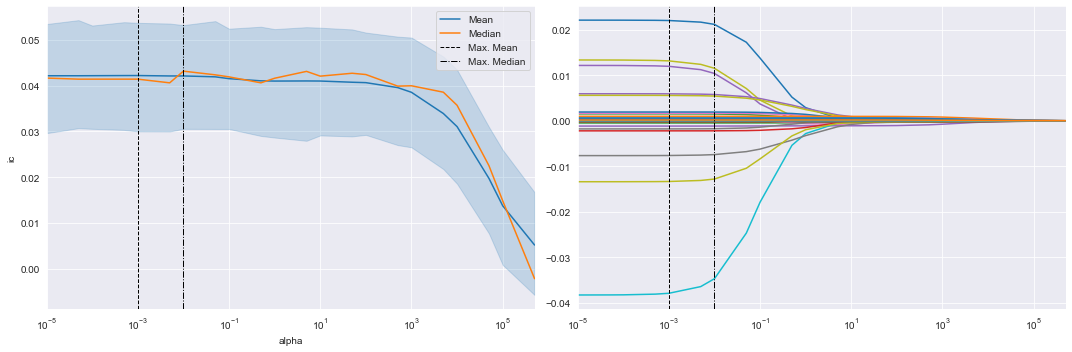

In [310]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

ax = sns.lineplot(x='alpha', y='ic', data=ridge_results,
                  estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = ridge_results.groupby('alpha').ic.agg(['mean', 'median'])
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')
axes[0].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1])
axes[1].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[1].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
fig.tight_layout()
fig.savefig('figures/ridge_path', dpi=300);

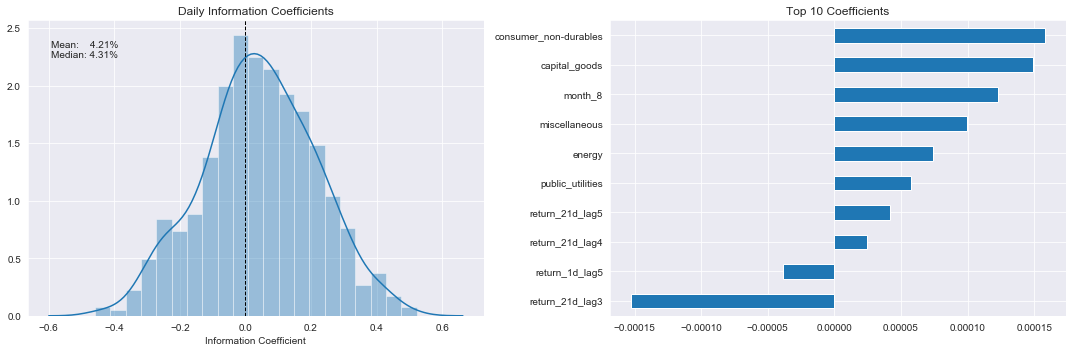

In [317]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_results[ridge_results.alpha==0.01], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[0.01].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[0.01, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')
fig.tight_layout()
fig.savefig('figures/ridge_top_coeffs', dpi=300);

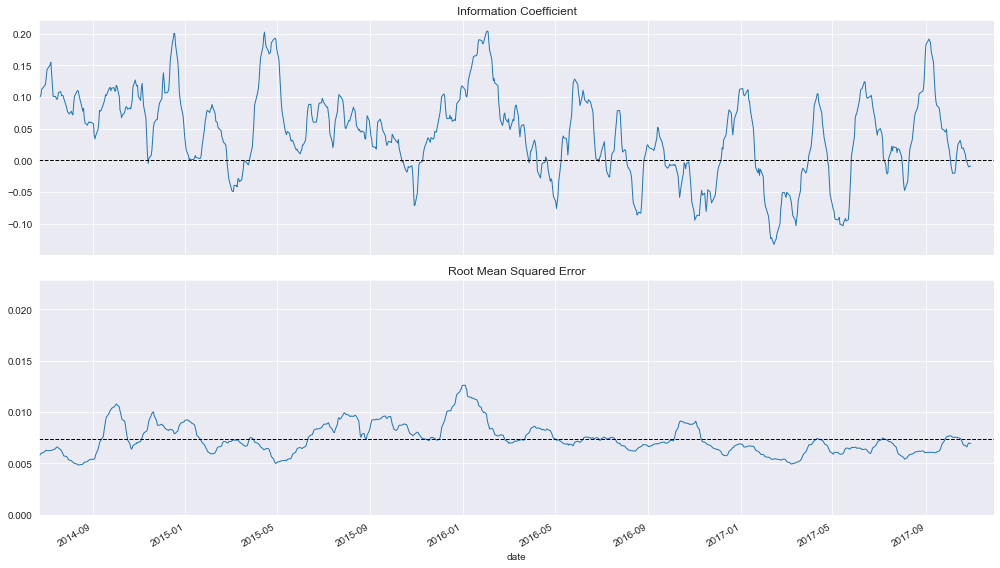

In [302]:
plot_rolling_ic(ridge_results[ridge_results.alpha==0.01].set_index('date'), fname='ridge_ic_rolling')

## Lasso CV

In [327]:
target = 'target_5d'
n_splits = 4*252
alphas = np.logspace(-14, -4, 11)
cv = TimeSeriesCV(n_splits=n_splits,
                  test_period_length=1,
                  train_period_length=252)
scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)
target = 'target_5d'
lasso_coeffs, coeffs, lasso_results, preds = {}, [], [], []
for alpha in alphas:
    model = Lasso(alpha=alpha,
                  fit_intercept=False,
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = rmses = 0
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        if len(y_test) < 10:
            continue
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        ic, pval = spearmanr(y_pred, y_test)

        preds.append(y_test.to_frame('actuals').assign(
            predicted=y_pred, alpha=alpha))
        date = y_test.index.get_level_values('date').min()
        lasso_results.append([alpha, i, date, rmse, ic, pval])
        coeffs.append(pipe['model'].coef_)
        ics += ic
        rmses += rmse
        if i % 100 == 0:
            print(f'{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {rmses/i:>7.2%}')

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

cols = ['alpha', 'split', 'date', 'rmse', 'ic', 'pval']
lasso_results = pd.DataFrame(lasso_results, columns=cols)
lasso_results.to_hdf('data.h5', 'lasso/metrics')
lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns)
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')
pd.concat(preds).to_hdf('data.h5', 'lasso/predictions')

5816.0 | 100 |   3.12% |   0.67%
5880.3 | 200 |   0.88% |   0.63%
5945.6 | 300 |   1.10% |   0.66%
6010.6 | 400 |   1.11% |   0.67%
6075.5 | 500 |   2.71% |   0.72%
6140.1 | 600 |   2.92% |   0.74%
6203.9 | 700 |   3.41% |   0.73%
6264.4 | 800 |   4.11% |   0.74%
6371.0 | 100 |   3.12% |   0.67%
6435.9 | 200 |   0.88% |   0.63%
6500.8 | 300 |   1.10% |   0.66%
6565.3 | 400 |   1.11% |   0.67%
6630.3 | 500 |   2.71% |   0.72%
6694.8 | 600 |   2.92% |   0.74%
6758.3 | 700 |   3.41% |   0.73%
6819.2 | 800 |   4.11% |   0.74%
6925.9 | 100 |   3.12% |   0.67%
6991.5 | 200 |   0.88% |   0.63%
7056.7 | 300 |   1.10% |   0.66%
7121.9 | 400 |   1.11% |   0.67%
7186.9 | 500 |   2.71% |   0.72%
7251.6 | 600 |   2.92% |   0.74%
7315.0 | 700 |   3.41% |   0.73%
7376.0 | 800 |   4.11% |   0.74%
7482.9 | 100 |   3.12% |   0.67%
7547.1 | 200 |   0.88% |   0.63%
7612.3 | 300 |   1.10% |   0.66%
7678.0 | 400 |   1.11% |   0.67%
7743.1 | 500 |   2.71% |   0.72%
7809.4 | 600 |   2.92% |   0.74%
7872.7 | 7

### Evaluate Lasso Results

In [328]:
lasso_results.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-14,0.043862,0.043641
1.000000e-13,0.043862,0.043641
1.000000e-12,0.043862,0.043641
1.000000e-11,0.043863,0.043641
1.000000e-10,0.043864,0.043641
1.000000e-09,0.043873,0.043641
1.000000e-08,0.043925,0.044465
1.000000e-07,0.043688,0.045195
1.000000e-06,0.040966,0.042103


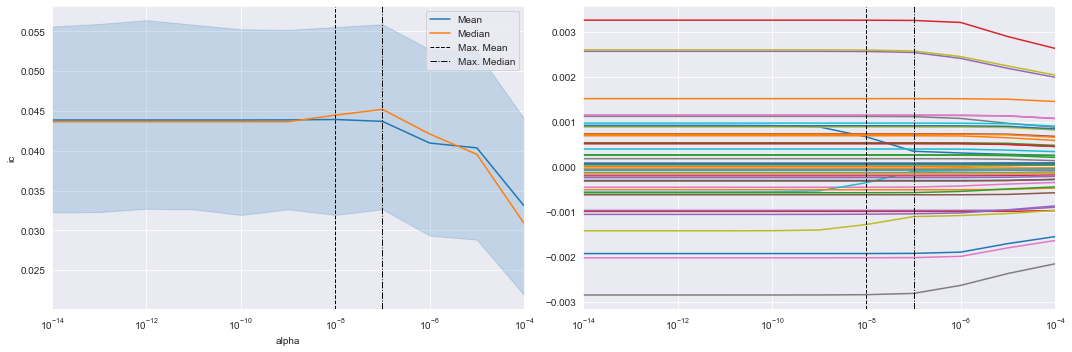

In [330]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

ax = sns.lineplot(x='alpha', y='ic', data=lasso_results,
                  estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = lasso_results.groupby('alpha').ic.agg(['mean', 'median'])
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')
axes[0].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')

lasso_coeffs.T.plot(logx=True,
                  legend=False,
                  ax=axes[1])
axes[1].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[1].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
fig.tight_layout()
fig.savefig('figures/lasso_path', dpi=300);

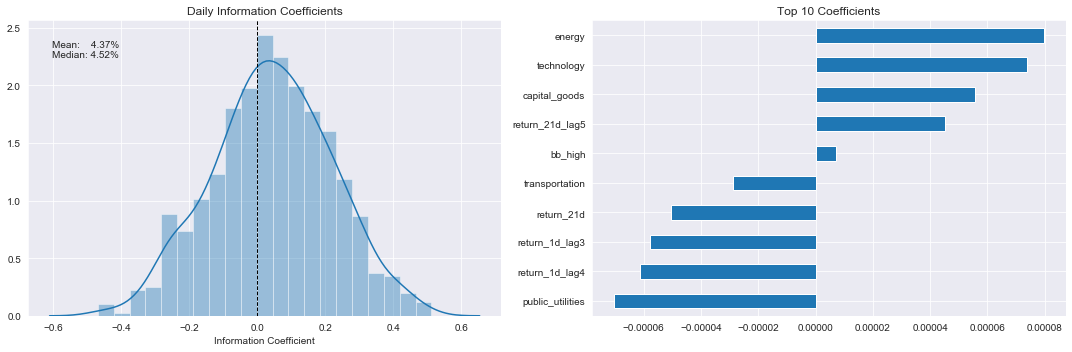

In [334]:
alpha = 1e-7
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_results[lasso_results.alpha==alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = lasso_coeffs.T.loc[alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.T.loc[alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')
fig.tight_layout()
fig.savefig('figures/lasso_top_coeffs', dpi=300);